# Dependencies

## Modules

In [1]:
!pip install --no-cache-dir torch transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 381.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 659.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 649.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 317.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.17
    Uninstalling multiprocess-0.70.17:
      Successfully uninstalled multiprocess-0.70.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.3 requi

In [2]:
!pip install --no-cache-dir seqeval==1.2.2 --use-pep517

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=fe544aa994fa0b7e8f4720840be550b5c4fd450ac827492174b2c8fbfc93dd02
  Stored in directory: /tmp/pip-ephem-wheel-cache-07qo1i80/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
!pip install --no-cache-dir optuna

## Imports

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
from seqeval.metrics import classification_report
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

Matplotlib is building the font cache; this may take a moment.


# Dataset

In [5]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [6]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenization and alignment
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [7]:
# DataLoader collate function
def collate_fn(batch):
    input_ids = [torch.tensor(x["input_ids"]) for x in batch]
    attention_mask = [torch.tensor(x["attention_mask"]) for x in batch]
    labels = [torch.tensor(x["labels"]) for x in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded,
    }

train_loader = DataLoader(tokenized_datasets["train"], batch_size=16, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=16, collate_fn=collate_fn)

# Model

In [8]:
class BertForNERWithLayerAttention(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(BertForNERWithLayerAttention, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
        self.num_hidden_layers = self.bert.config.num_hidden_layers + 1 
        self.layer_weights = nn.Parameter(torch.ones(self.num_hidden_layers))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)  # (num_layers, batch_size, seq_len, hidden_size)
        weighted_hidden_states = torch.sum(self.layer_weights[:, None, None, None] * hidden_states, dim=0)
        sequence_output = self.dropout(weighted_hidden_states)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, logits.size(-1))[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

In [9]:
# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForNERWithLayerAttention(pretrained_model_name="bert-base-cased", num_labels=num_labels).to(device)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Training

In [10]:
# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")

Epoch 1: 100%|██████████| 878/878 [01:15<00:00, 11.65it/s]


Epoch 1 Loss: 0.5253659653293948


Epoch 2: 100%|██████████| 878/878 [00:49<00:00, 17.82it/s]


Epoch 2 Loss: 0.1434093017832039


Epoch 3: 100%|██████████| 878/878 [00:49<00:00, 17.78it/s]

Epoch 3 Loss: 0.06444175787890495


## Evaluation

In [11]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        preds = torch.argmax(logits, dim=-1)

        for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
            true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

print(classification_report(true_labels, predictions))

Evaluating: 100%|██████████| 204/204 [00:04<00:00, 46.10it/s]


              precision    recall  f1-score   support

         LOC       0.95      0.94      0.94      3635
        MISC       0.80      0.85      0.82      1480
         ORG       0.91      0.89      0.90      2702
         PER       0.96      0.93      0.95      3329

   micro avg       0.92      0.91      0.92     11146
   macro avg       0.90      0.90      0.90     11146
weighted avg       0.92      0.91      0.92     11146



# Hyperparameter Tuning

## Optuna Study

In [12]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_epochs = 3

    # Define model with trial's hyperparameters
    class BertForNER(nn.Module):
        def __init__(self, pretrained_model_name, num_labels):
            super(BertForNER, self).__init__()
            self.bert = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
            self.num_hidden_layers = self.bert.config.num_hidden_layers + 1
            self.layer_weights = nn.Parameter(torch.ones(self.num_hidden_layers))
            self.dropout = nn.Dropout(dropout_rate)  # Use trial's dropout rate
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        def forward(self, input_ids, attention_mask, labels=None):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = torch.stack(outputs.hidden_states, dim=0)  # (num_layers, batch_size, seq_len, hidden_size)
            weighted_hidden_states = torch.sum(self.layer_weights[:, None, None, None] * hidden_states, dim=0)
            sequence_output = self.dropout(weighted_hidden_states)
            logits = self.classifier(sequence_output)

            loss = None
            if labels is not None:
                loss_fn = nn.CrossEntropyLoss()
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, logits.size(-1))[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fn(active_logits, active_labels)

            return {"loss": loss, "logits": logits}

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertForNER(pretrained_model_name="bert-base-cased", num_labels=num_labels).to(device)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Prepare data loaders
    train_loader = DataLoader(tokenized_datasets["train"], batch_size=batch_size, collate_fn=collate_fn)
    val_loader = DataLoader(tokenized_datasets["validation"], batch_size=batch_size, collate_fn=collate_fn)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=-1)

            for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
                predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
                true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

    # Compute F1-score
    f1 = f1_score([label for seq in true_labels for label in seq],
                  [label for seq in predictions for label in seq],
                  average="weighted")
    return f1

In [13]:
# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Try 20 different combinations

# Print best parameters
print("Best hyperparameters:", study.best_params)

[I 2024-12-09 20:26:33,093] A new study created in memory with name: no-name-d3fd9897-1d25-4f9d-a5f9-684f1f3e0da8
/tmp/ipykernel_15366/3088590689.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipykernel_15366/3088590689.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
Epoch 3: 100%|██████████| 1756/1756 [01:18<00:00, 22.27it/s]
[I 2024-12-09 20:30:36,510] Trial 0 finished with value: 0.9625228572100585 and parameters: {'learning_rate': 0.000141150884172717, 'dropout_rate': 0.11722622565477665, 'batch_size': 8}. Best is trial 0 with value: 0.962

Best hyperparameters: {'learning_rate': 4.369484270668493e-05, 'dropout_rate': 0.33027803609683487, 'batch_size': 32}


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 439/439 [00:42<00:00, 10.24it/s]


Epoch 1 Training Loss: 0.6829
Epoch 1 Validation Loss: 0.1561
Validation loss improved to 0.1561.


Training Epoch 2: 100%|██████████| 439/439 [00:41<00:00, 10.62it/s]


Epoch 2 Training Loss: 0.1782
Epoch 2 Validation Loss: 0.1235
Validation loss improved to 0.1235.


Training Epoch 3: 100%|██████████| 439/439 [00:41<00:00, 10.60it/s]


Epoch 3 Training Loss: 0.0810
Epoch 3 Validation Loss: 0.1025
Validation loss improved to 0.1025.


Training Epoch 4: 100%|██████████| 439/439 [00:41<00:00, 10.61it/s]


Epoch 4 Training Loss: 0.0467
Epoch 4 Validation Loss: 0.1202
No improvement for 1 epochs.


Training Epoch 5: 100%|██████████| 439/439 [00:41<00:00, 10.60it/s]


Epoch 5 Training Loss: 0.0296
Epoch 5 Validation Loss: 0.1404
No improvement for 2 epochs.


Training Epoch 6: 100%|██████████| 439/439 [00:41<00:00, 10.60it/s]


Epoch 6 Training Loss: 0.0222
Epoch 6 Validation Loss: 0.1315
No improvement for 3 epochs.


Training Epoch 7: 100%|██████████| 439/439 [00:41<00:00, 10.60it/s]


Epoch 7 Training Loss: 0.0230
Epoch 7 Validation Loss: 0.1305
No improvement for 4 epochs.


Training Epoch 8: 100%|██████████| 439/439 [00:41<00:00, 10.61it/s]


Epoch 8 Training Loss: 0.0148
Epoch 8 Validation Loss: 0.1382
No improvement for 5 epochs.


Training Epoch 9: 100%|██████████| 439/439 [00:41<00:00, 10.61it/s]


Epoch 9 Training Loss: 0.0182
Epoch 9 Validation Loss: 0.1533
No improvement for 6 epochs.


Training Epoch 10: 100%|██████████| 439/439 [00:41<00:00, 10.61it/s]


Epoch 10 Training Loss: 0.0109
Epoch 10 Validation Loss: 0.1607
No improvement for 7 epochs.


Training Epoch 11: 100%|██████████| 439/439 [00:41<00:00, 10.61it/s]


Epoch 11 Training Loss: 0.0091
Epoch 11 Validation Loss: 0.1826
No improvement for 8 epochs.


Training Epoch 12: 100%|██████████| 439/439 [00:41<00:00, 10.61it/s]


Epoch 12 Training Loss: 0.0074
Epoch 12 Validation Loss: 0.1589
No improvement for 9 epochs.


Training Epoch 13: 100%|██████████| 439/439 [00:41<00:00, 10.60it/s]


Epoch 13 Training Loss: 0.0102
Epoch 13 Validation Loss: 0.1781
No improvement for 10 epochs.
Early stopping triggered. Training stopped.
Classification Report:
              precision    recall  f1-score   support

           O       0.97      0.95      0.96      3635
       B-PER       0.85      0.90      0.88      1480
       I-PER       0.92      0.92      0.92      2702
       B-ORG       0.96      0.96      0.96      3329
       I-ORG       0.92      0.92      0.92       381
       B-LOC       0.81      0.82      0.82       591
       I-LOC       0.91      0.90      0.90      1079
      B-MISC       0.99      0.98      0.99      3028
      I-MISC       1.00      1.00      1.00     51723

    accuracy                           0.98     67948
   macro avg       0.92      0.93      0.93     67948
weighted avg       0.98      0.98      0.98     67948

Validation Accuracy: 0.9821
Validation F1 Score: 0.9822


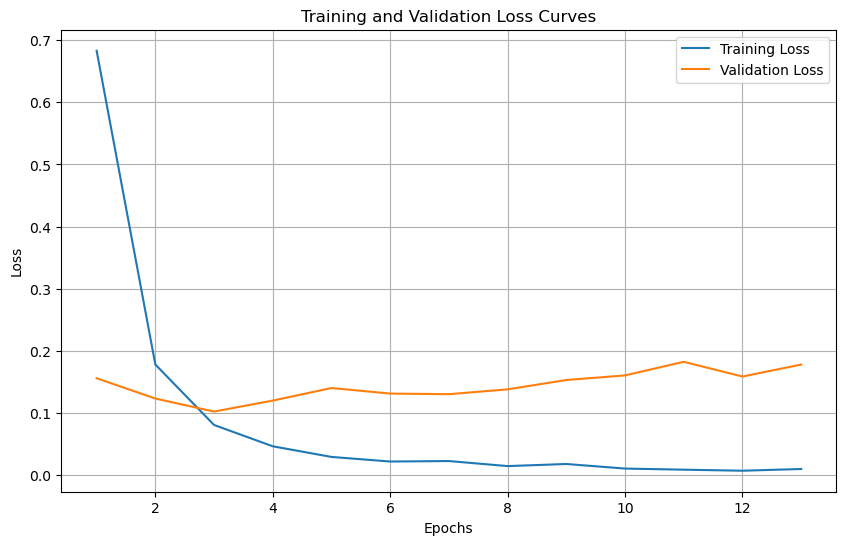

In [18]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from transformers import AdamW
from tqdm import tqdm

# Define the final model
class BertForFinalNER(nn.Module):
    def __init__(self, pretrained_model_name, num_labels, dropout_rate):
        super(BertForFinalNER, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name, output_hidden_states=True)
        self.num_hidden_layers = self.bert.config.num_hidden_layers + 1
        self.layer_weights = nn.Parameter(torch.ones(self.num_hidden_layers))
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)
        weighted_hidden_states = torch.sum(self.layer_weights[:, None, None, None] * hidden_states, dim=0)
        sequence_output = self.dropout(weighted_hidden_states)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, logits.size(-1))[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

# Retrieve best parameters
best_params = study.best_params

# Instantiate the model with best dropout rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForFinalNER(pretrained_model_name="bert-base-cased", num_labels=num_labels, dropout_rate=best_params["dropout_rate"]).to(device)

# Define the optimizer with the best learning rate
optimizer = AdamW(model.parameters(), lr=best_params["learning_rate"])

# Prepare data loaders with the best batch size
train_loader = DataLoader(tokenized_datasets["train"], batch_size=best_params["batch_size"], collate_fn=collate_fn)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=best_params["batch_size"], collate_fn=collate_fn)

# Track loss values
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change to qualify as improvement
best_val_loss = float("inf")
epochs_without_improvement = 0

# Training and validation loops
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    total_val_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            total_val_loss += loss.item()

            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=-1)

            for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
                predictions.append([label_list[p] for p, l in zip(pred, label) if l != -100])
                true_labels.append([label_list[l] for p, l in zip(pred, label) if l != -100])

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")

    # Check for improvement
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        print(f"Validation loss improved to {avg_val_loss:.4f}.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs.")

    # Early stopping
    if epochs_without_improvement >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Compute evaluation metrics
flattened_preds = [label for seq in predictions for label in seq]
flattened_labels = [label for seq in true_labels for label in seq]

accuracy = accuracy_score(flattened_labels, flattened_preds)
f1 = f1_score(flattened_labels, flattened_preds, average="weighted")

# Print the complete classification report
print("Classification Report:")
print(classification_report(flattened_labels, flattened_preds, target_names=label_list))

# Print accuracy and F1 score
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid()
plt.show()
